# Exploration of activity changes

This notebook explores the following features of neural activity:

- Decoding
    - Using
        - Logistic Regression
        - Random forest
        - XGBoost
    - Model characteristics
        - Confusion matrix
        - "Distance"/"predict_proba" matrices
        - Feature importances
    - Comparing
        - Before/after changepoint
        - Autoshape/DRRD
        

- Differences
    - Comparing
        - Before/after changepoint
        - Autoshape/DRRD
    - Measures 
        - Distances
        - Similarities
        - Synchronization
        - Via spikeutils

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Exploration-of-activity-changes" data-toc-modified-id="Exploration-of-activity-changes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploration of activity changes</a></div><div class="lev1 toc-item"><a href="#Encoding" data-toc-modified-id="Encoding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Encoding</a></div><div class="lev1 toc-item"><a href="#Feature-importances" data-toc-modified-id="Feature-importances-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature importances</a></div><div class="lev2 toc-item"><a href="#XGBoost" data-toc-modified-id="XGBoost-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>XGBoost</a></div><div class="lev2 toc-item"><a href="#ElasticNet" data-toc-modified-id="ElasticNet-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>ElasticNet</a></div><div class="lev2 toc-item"><a href="#rbfSVM" data-toc-modified-id="rbfSVM-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>rbfSVM</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Logistic Regression</a></div>

# Encoding

In [158]:
def encode_by_rate_quantile(X, q):
    le, oh = LabelEncoder(), OneHotEncoder()
    
    df = pd.DataFrame(X).apply(lambda x: pd.qcut(x, q, duplicates='drop'))
    df = df.apply(lambda x: le.fit_transform(x))
    sp = pd.DataFrame(index=df.index)
    
    for i in df.columns:
        sp = sp.join(pd.DataFrame(oh.fit_transform(df[i].values.reshape(-1,1)).todense()), rsuffix='_unit_%d'%i, lsuffix='_unit_%d'%i)
    
    return sp

# Feature importances

In [1]:
import os
os.chdir('../../')

import pandas as pd
import numpy as np

In [34]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_predict, GroupKFold
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
from spikelearn.data import io
from spikelearn.data.selection import select, to_feature_array

In [6]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
rat = 'DRRD 8'
s = io.load(rat, 'wide_smoothed')

## XGBoost

In [9]:
from xgboost import XGBClassifier

In [14]:
params = io.load(rat, 'XGboost')

In [15]:
params = dict(zip(params.columns, params.values.reshape(-1)))

In [16]:
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_child_weight'] = int(params['min_child_weight'])

In [94]:
X,y, trial = to_feature_array(select(s.reset_index(), _min_duration=1.5, _min_trial=100, is_tired=False).set_index(['trial','unit']), subset='cropped')

In [423]:
df = encode_by_rate_quantile(X, 10)

In [142]:
clf = XGBClassifier()

In [91]:
preds = cross_val_predict(clf, X, y, trial, GroupKFold(5))

KeyboardInterrupt: 

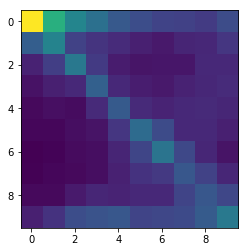

In [38]:
plt.imshow(confusion_matrix(preds,y))

In [125]:
def shuffle_val_predict(clf, X, y, group=None, cv=GroupKFold(5), method='predict'):
    def get_predictions_or_proba(clf, X, mode):
        """
        Local helper function to ease the switching between predict_proba and predict
        """
        if mode == 'predict':
            return pd.DataFrame(clf.predict(X), columns=['predictions'])
        elif mode in ['proba','probability']:
            try:
                return pd.DataFrame(clf.predict_proba(X), columns=np.unique(y))
            except:
                return pd.DataFrame(clf.decision_function(X), columns=np.unique(y))

    results = pd.DataFrame()
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y, group)):
        clf_local = clone(clf)
        clf_local.fit(X[train_idx,:],y[train_idx])

        predictions = get_predictions_or_proba(clf_local, X[test_idx], method )
        predictions['cv'] = i
        predictions['group'] = group[test_idx]
        predictions['true'] = y[test_idx]
        results = results.append(predictions)
    return results

In [161]:
c = shuffle_val_predict(clf, X, y, trial, GroupShuffleSplit(10, 10, 80),'proba')

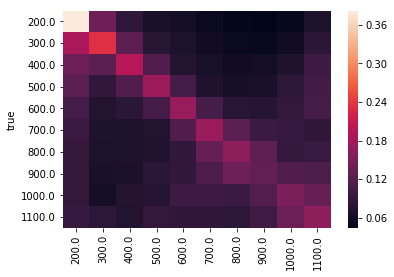

In [162]:
sns.heatmap(c.drop(['cv','group'],axis=1).groupby('true').mean())

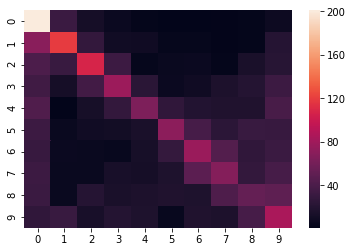

In [144]:
sns.heatmap(confusion_matrix(c.true,c.predictions))

In [397]:
l = LabelEncoder()
t = l.fit_transform(results.true)
p = l.transform(results.predictions)

In [147]:
%time clf.fit(X,y)

CPU times: user 3.87 s, sys: 0 ns, total: 3.87 s
Wall time: 3.87 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<Container object of 28 artists>

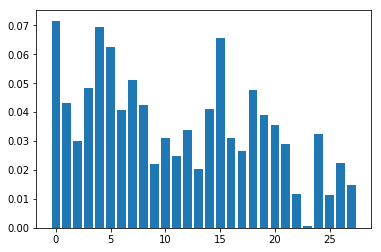

In [167]:
plt.bar(np.arange(X.shape[1]),clf.feature_importances_)

## ElasticNet

In [127]:
from sklearn.linear_model import SGDClassifier

In [125]:
params = io.load('DRRD 7', 'elasticnet_SGD')
params= dict(zip(params.columns, params.values.reshape(-1)))

In [129]:
clf = SGDClassifier(loss='log', penalty='elasticnet',
                                    tol=1e-5, **params)

In [139]:
def get_predictions_or_proba(clf, X, mode):
    """
    Local helper function to ease the switching between predict_proba and predict
    """
    if mode == 'predict':
        return clf.predict(X)
    elif mode in ['proba','probability']:
        try:
            return clf.predict_proba(X)
        except:
            return clf.decision_function(X)
n_shuffles=20
train_size=.8
test_size=.2

results = pd.DataFrame(columns = ['trial', 'shuffle', 'predictions','true'])
sh = GroupShuffleSplit(n_splits=n_shuffles, train_size=train_size,test_size=test_size)

for i, (train_idx, test_idx) in enumerate(sh.split(X,y,trial)):
    clf_local = clone(clf)
    clf_local.fit(X[train_idx,:],y[train_idx])

    predictions = get_predictions_or_proba(clf_local, X[test_idx], 'predict' )
    true = y[test_idx]
    results = results.append(pd.DataFrame({'shuffle':i, 'predictions': predictions,
                                            'trial':trial[test_idx], 'true':true} ) )

In [140]:
l = LabelEncoder()
t = l.fit_transform(results.true)
p = l.transform(results.predictions)

In [143]:
confusion_matrix(t,p)

array([[655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0],
       [655, 262, 131, 393, 393, 131, 131, 262, 262,   0]])

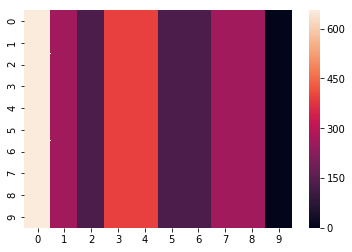

In [144]:
sns.heatmap(confusion_matrix(t, p))

## rbfSVM

In [148]:
from sklearn.svm import SVC

In [145]:
params = io.load('DRRD 7', 'rbfSVM')
params= dict(zip(params.columns, params.values.reshape(-1)))

In [149]:
clf = SVC(**params)

In [150]:
def get_predictions_or_proba(clf, X, mode):
    """
    Local helper function to ease the switching between predict_proba and predict
    """
    if mode == 'predict':
        return clf.predict(X)
    elif mode in ['proba','probability']:
        try:
            return clf.predict_proba(X)
        except:
            return clf.decision_function(X)
n_shuffles=10
train_size=.8
test_size=.2

results = pd.DataFrame(columns = ['trial', 'shuffle', 'predictions','true'])
sh = GroupShuffleSplit(n_splits=n_shuffles, train_size=train_size,test_size=test_size)

for i, (train_idx, test_idx) in enumerate(sh.split(X,y,trial)):
    clf_local = clone(clf)
    clf_local.fit(X[train_idx,:],y[train_idx])

    predictions = get_predictions_or_proba(clf_local, X[test_idx], 'predict' )
    true = y[test_idx]
    results = results.append(pd.DataFrame({'shuffle':i, 'predictions': predictions,
                                            'trial':trial[test_idx], 'true':true} ) )

In [151]:
l = LabelEncoder()
t = l.fit_transform(results.true)
p = l.transform(results.predictions)

In [152]:
confusion_matrix(t,p)

array([[793,  83,  45,  49,  43,  39,  30,  41,  50, 137],
       [759,  76,  37,  64,  49,  42,  29,  50,  57, 147],
       [728,  76,  35,  71,  49,  43,  40,  57,  61, 150],
       [705,  64,  31,  78,  57,  46,  41,  67,  67, 154],
       [673,  72,  35,  70,  65,  52,  42,  66,  79, 156],
       [645,  72,  39,  69,  69,  57,  50,  76,  71, 162],
       [639,  70,  35,  69,  69,  61,  51,  82,  74, 160],
       [632,  72,  36,  73,  65,  58,  52,  84,  79, 159],
       [627,  74,  34,  73,  58,  60,  50,  85,  82, 167],
       [623,  80,  35,  77,  54,  56,  49,  89,  79, 168]])

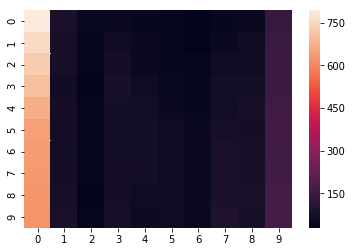

In [153]:
sns.heatmap(confusion_matrix(t, p))

## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression

In [145]:
params = io.load('DRRD 7', 'rbfSVM')
params= dict(zip(params.columns, params.values.reshape(-1)))

In [71]:
clf = LogisticRegression(C=.01)

In [370]:
def get_predictions_or_proba(clf, X, mode):
    """
    Local helper function to ease the switching between predict_proba and predict
    """
    if mode == 'predict':
        return clf.predict(X)
    elif mode in ['proba','probability']:
        try:
            return clf.predict_proba(X)
        except:
            return clf.decision_function(X)
n_shuffles=20
train_size=.8
test_size=.2

results = pd.DataFrame(columns = ['trial', 'shuffle', 'predictions','true'])
sh = GroupShuffleSplit(n_splits=n_shuffles, train_size=train_size,test_size=test_size)

for i, (train_idx, test_idx) in enumerate(sh.split(X,y,trial)):
    clf_local = clone(clf)
    clf_local.fit(X[train_idx,:],y[train_idx])

    predictions = get_predictions_or_proba(clf_local, X[test_idx], 'predict' )
    true = y[test_idx]
    results = results.append(pd.DataFrame({'shuffle':i, 'predictions': predictions,
                                            'trial':trial[test_idx], 'true':true} ) )

In [371]:
l = LabelEncoder()
t = l.fit_transform(results.true)
p = l.transform(results.predictions)

In [372]:
confusion_matrix(t,p)

array([[1259,  264,  128,   99,  112,   93,  102,  100,  171,  292],
       [1131,  253,  118,  104,  147,  105,  123,  132,  173,  334],
       [1019,  239,  111,  122,  140,  125,  107,  179,  200,  378],
       [ 936,  203,  110,  127,  142,  115,  146,  184,  233,  424],
       [ 850,  200,  116,  136,  139,  121,  152,  232,  219,  455],
       [ 796,  166,  112,  134,  171,  112,  175,  218,  252,  484],
       [ 750,  157,  104,  121,  165,  126,  179,  225,  242,  551],
       [ 703,  163,  115,  117,  162,  120,  165,  240,  262,  573],
       [ 706,  163,  106,  134,  136,  123,  164,  228,  282,  578],
       [ 738,  169,  106,  117,  131,  122,  141,  231,  291,  574]])

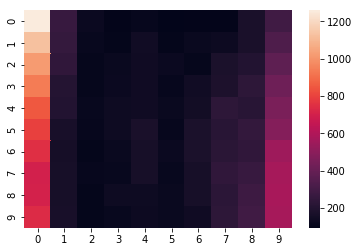

In [373]:
sns.heatmap(confusion_matrix(t, p))